In [209]:
import pandas as pd
import re
import plotly.express as px
import os
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import dateutil.parser as parser
from datetime import datetime
from rake_nltk import Rake
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans

In [210]:
def prepare_data():
    # Import data
    df = pd.read_csv('email headers.csv', sep=",")
    # Fix columns
    df['From'].astype(str)
    df['Date'] = pd.to_datetime(df['Date'])
    # df['Sender'] = [x.split('@')[0] for x in df['From']]
    # df['Sender'] = [x.replace('.', ', ') for x in df['Sender']]
 
    return df

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    words = [word for word in tokens if word.isalpha() and word not in stop_words]
    words = ' '.join(words)
    return words

def all_text(in_dir):
    '''
    Loops over all articles and outputs a dictionary with the file name as key, 
    and as value a tuple with the date and the tokenized text.
    @in_dir: the directory of the articles
    '''
    alltext = {}
    date_pattern = r"(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})|([A-Z][a-z]{2}\s\d{1,2},?\s\d{2,4})|(\d{4}[/-]\d{2}[/-]\d{2}|\b\d{1,2}\s+(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{4}\b)"

    rake_nltk_var = Rake()

    for file_name in os.listdir(in_dir):
        if file_name.endswith('.txt'):
            input_path  = os.path.join(in_dir, file_name)
            with open(input_path, 'r') as infile:
                text = infile.read()
                # Find all matches of the date pattern in the text
                results = re.findall(date_pattern, text)
                for i in results:
                    for j in i:
                        if j != '':
                            article_date = j
                            article_date = parser.parse(article_date)
                            article_date = article_date.strftime("%Y/%m/%d")
                cleaned_text = clean_text(text)
                # rake_nltk_var.extract_keywords_from_text(cleaned_text)
                # keyword_extracted = rake_nltk_var.get_ranked_phrases()
                alltext[file_name] = [article_date, cleaned_text]

    return alltext



def find_keywords(all_text):
    pass

In [211]:
in_dir = "C:/Users/didov/Desktop/DS&AI/Q3_VisualAnalytics/Visual_Analytics/Disappearance at GAStech/data/data_prep/articles"
alltext = all_text(in_dir)

In [212]:

sentence = alltext['0.txt'][1]
# lemmatizer = WordNetLemmatizer()
# out = " ".join([lemmatizer.lemmatize(wd) for wd in sentence.split()])
nodate={}
dates={}
for key, value in alltext.items():
#     for i in value[1].split():
#         if i == 'aardgasbedrijf':
#             print(key)
    nodate[key] = value[1]
    dates[key] = value[0]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(list(nodate.values()))
word_list = vectorizer.get_feature_names_out()

df = pd.DataFrame(X.todense(), index=nodate.keys(), columns=vectorizer.get_feature_names_out())


df.head()
# Added [0] here to get a 1d-array for iteration by the zip function. 
# count_list = np.asarray(X.sum(axis=0))[0]
# word_counts = dict(zip(word_list, count_list))
# l = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
# print(l) 


,aan,aaningen,aardgas,aardgasbedrijf,aardgasboring,aardgasexploratie,aardgasverwerking,abandonment,abducted,abduction,...,zone,zoon,zoonssten,zowat,zuurrijke,zwartbeklede,zwarte,éramos,étincelant,étincelé
0.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101.txt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
df['Date'] = dates
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

df[['kronos', 'Date']]

,kronos,Date
37.txt,1,1982-02-17
205.txt,1,1982-02-17
839.txt,1,1982-02-17
696.txt,1,1982-02-17
255.txt,1,1982-02-17
...,...,...
656.txt,15,2014-03-26
687.txt,0,2014-03-26
55.txt,3,2014-03-26
234.txt,0,2014-03-26


In [223]:
def plot_timeline(dataframe, keywords):
    keywords = [keyword.lower() for keyword in keywords]
    keywords.append('Date')
    df = dataframe[keywords]
    df_long = df.melt(id_vars='Date', var_name='Word', value_name='Frequency')
    fig = px.histogram(df_long, x='Date', y='Frequency', title='Occurance of keywords', color='Word', color_discrete_sequence=px.colors.qualitative.Safe)
    fig.update_xaxes(rangeslider_visible=True)
    
    fig.show()
    
plot_timeline(df, ['Death', 'Fire', 'Pok'])

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

corpus = nodate.values()
KM = KMeans(n_clusters=12, random_state=0, n_init="auto")
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus)



KM.fit(X)
# labels = km.labels_
prediction = KM.predict(X)
# plt.scatter(km[:, 0], km[:, 1], c=labels, s=50, cmap='viridis')
# plt.show()

In [216]:
# df = pd.DataFrame.from_dict(nodate, orient='index', columns=['Text'])
# new_X = vectorizer.fit_transform(df['Text'])

C:\Users\didov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



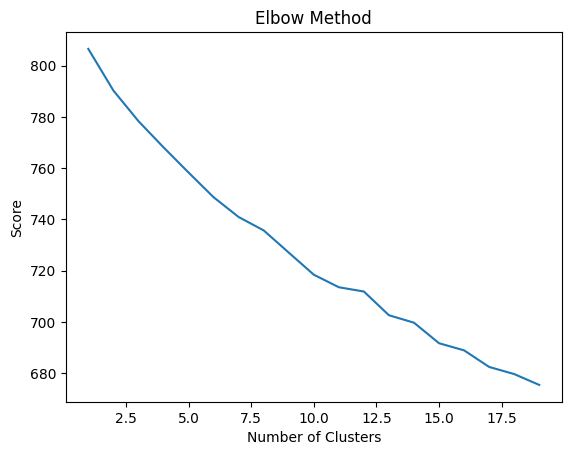

In [217]:
def elbow_method(Y_sklearn):
    """
    This is the function used to get optimal number of clusters in order to feed to the k-means clustering algorithm.
    """

    number_clusters = range(1, 20)  # Range of possible clusters that can be generated
    kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters] # Getting no. of clusters 

    score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))] # Getting score corresponding to each cluster.
    score = [i*-1 for i in score] # Getting list of positive scores.
    
    plt.plot(number_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')
    plt.show()

    
elbow_method(X)

C:\Users\didov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


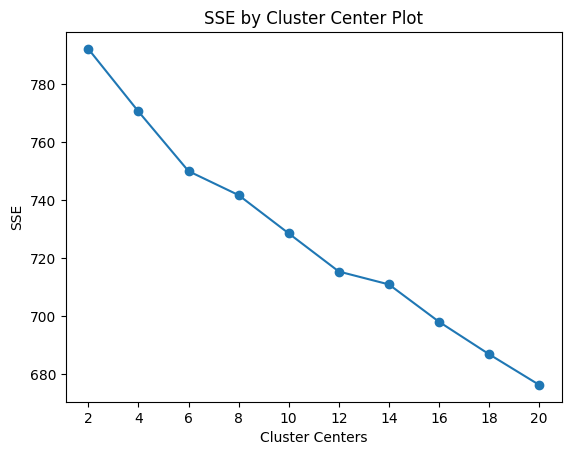

In [168]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 20)

In [206]:
def plot_tsne_pca(data, labels):
    pca = PCA(n_components=2).fit_transform(np.asarray(data.todense()))
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(np.asarray(data.todense())))

    cluster_keywords = get_top_keywords(data, prediction, vectorizer.get_feature_names_out(), 5)
    new_labels = [cluster_keywords[i] for i in labels]
   
    fig = px.scatter(x=pca[:, 0], y=pca[:, 1], title="PCA Cluster plot", color=new_labels, color_discrete_sequence=px.colors.qualitative.Safe)
    fig.show()
    
    fig2 = px.scatter(x=tsne[:, 0], y=tsne[:, 1], color=new_labels, title="TSNE Cluster plot", color_discrete_sequence=px.colors.qualitative.Safe)
    fig2.show()
    
plot_tsne_pca(X, prediction)

In [170]:
KM.get_feature_names_out()

array(['kmeans0', 'kmeans1', 'kmeans2', 'kmeans3', 'kmeans4', 'kmeans5',
       'kmeans6', 'kmeans7', 'kmeans8', 'kmeans9', 'kmeans10', 'kmeans11'],
      dtype=object)

In [171]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    keyword_dict = {}
    for i,r in df.iterrows():
        keyword_dict[i] = ', '.join([labels[t] for t in np.argsort(r)[-n_terms:]])
        
    return keyword_dict
            
get_top_keywords(X, prediction, vectorizer.get_feature_names_out(), 5)

{0: 'opening, sanjorge, kleptocracy, kronos, gastechkronos',
 1: 'gastech, company, fluss, sanjorge, gas',
 2: 'damage, protestors, rally, gastech, pok',
 3: 'trapani, cato, rossini, updates, building',
 4: 'jr, international, sanjorge, kronos, gastech',
 5: 'centrum, voices, approximately, sentinel, gen',
 6: 'oil, nespola, kapelou, minister, health',
 7: 'gastech, modernizations, quarters, modernization, construction',
 8: 'kronos, leader, death, elian, karel',
 9: 'abila, police, government, kronos, pok',
 10: 'wellness, family, report, health, elodis',
 11: 'maha, salo, homeland, illumination, jan'}

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

pca = PCA(n_components=100).fit_transform(np.asarray(X.todense()))


X_train, X_test, y_train, y_test = train_test_split(np.asarray(X.todense()), prediction, test_size=0.2)


model = SVC(kernel='linear', C=1, decision_function_shape='ovr').fit(X_train, y_train)

model.score(X_test, y_test)



0.9704142011834319

In [227]:
# Convert the processed query into a tf-idf vector
from sklearn.metrics.pairwise import cosine_similarity

query_vector = vectorizer.transform(['police'])

# Compute the cosine similarity between the query vector and all article vectors
similarity_scores = cosine_similarity(X, query_vector)

# Get the indices of the most similar articles

most_similar_indices = similarity_scores.argsort(axis=0)[::-1][:10]


article_titles = list(nodate.keys())

most_similar_articles = [(article_titles[int(i[0])], similarity_scores[i][0][0]*100) for i in most_similar_indices]

# Print the titles of the most similar articles
most_similar_articles

[('276.txt', 25.364409281228028),
 ('766.txt', 25.064658944528745),
 ('676.txt', 24.819751342346173),
 ('193.txt', 22.828388677721616),
 ('356.txt', 22.71918402071176),
 ('89.txt', 22.657147584709758),
 ('532.txt', 22.613510077505214),
 ('57.txt', 22.523984729813808),
 ('21.txt', 22.431942809675924),
 ('163.txt', 22.387557939416638)]

In [228]:
preprocess = np.asarray(query_vector.todense())
model.predict(preprocess)

array([9])

In [204]:
df = pd.DataFrame(most_similar_articles, columns=['Article Title', 'Cosine Similarity Score (%)'])
fig = px.bar(df, x='Cosine Similarity Score (%)', y='Article Title', title='Cosine Similariy for the word "Kidnapping"', color='Article Title', color_discrete_sequence=px.colors.qualitative.Safe, orientation='h')
fig.show()